# Modeling Exercises
The end result of this exercise should be a Jupyter notebook named model.

### Part 1
Using saas.csv or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.


### Optional 
Using store item demand

1. Predict 2018 total monthly sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.


<hr style="border:2px solid black"> </hr>

In [1]:
#imports

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")


In [32]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(train['Amount'], yhat_df[target_var])), 0)
    return rmse


In [33]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [34]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var, eval_df):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [6]:
def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [amt]},
                          index=validate.index)
    return yhat_df

<hr style="border:2px solid black"> </hr>

## Part 1

In [7]:
df = pd.read_csv('saas.csv')

In [8]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [10]:
#check current dtype- object
df.Month_Invoiced.dtypes

dtype('O')

In [11]:
df.Month_Invoiced = df.Month_Invoiced.astype('datetime64[ns]')

In [12]:
#must complete step 2&3 (set date as index and sort)
df = df.set_index('Month_Invoiced').sort_index()

In [13]:
#confirm index changed
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<hr style="border:1px solid black"> </hr>

### 1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [14]:
# set train size to be 50% of total 
train_size = int(len(df) * 0.5)
train_size

395229

In [15]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size

237137

In [16]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

158092

In [17]:
validate_end_index = train_size + validate_size
validate_end_index

632366

In [18]:
# train 
train = df[:train_size]
# validate
validate = df[train_size:validate_end_index]
# test 
test = df[validate_end_index:]

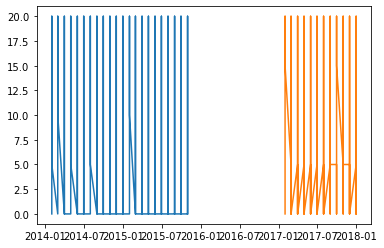

In [19]:
plt.plot(train.index, train.Amount)
plt.plot(test.index, test.Amount)

In [20]:
y = train.Amount

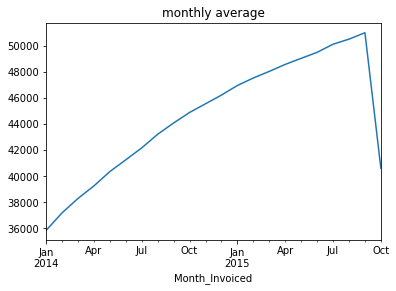

In [21]:
#resample every month and use average
y.resample('M').sum().plot(title='monthly average')
None

In [22]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


<hr style="border:2px solid black"> </hr>

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:

In [40]:
#Create the empty dataframe and define the columns
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [41]:
#function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### 2a. Simple Average

In [28]:
#create df with average amount
#train set only
yhat_df = pd.DataFrame({'mean_predicted': train['Amount'].mean()}, 
                      index = train.index)

In [29]:
yhat_df.head()

,mean_predicted
Month_Invoiced,
2014-01-31,2.479676
2014-01-31,2.479676
2014-01-31,2.479676
2014-01-31,2.479676
2014-01-31,2.479676


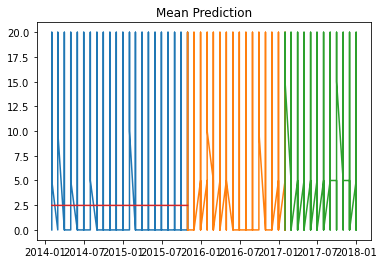

In [36]:
plt.plot(train['Amount'])
plt.plot(validate['Amount'])
plt.plot(test['Amount'])
plt.plot(yhat_df['mean_predicted'])
plt.title('Mean Prediction')
None

KeyError: 'Amount'

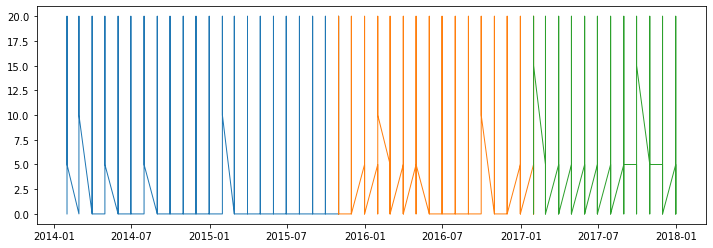

In [38]:
target_var = 'Amount'
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label='Train', linewidth=1)
plt.plot(validate[target_var], label='Validate', linewidth=1)
plt.plot(test[target_var], label='Test', linewidth=1)
plt.plot(yhat_df[target_var])
plt.title(target_var)
rmse = evaluate(target_var)
print(target_var, '-- RMSE: {:.0f}'.format(rmse))
plt.show()

<hr style="border:1px solid black"> </hr>

### 2b. Moving Average

In [44]:
# moving Average
periods = [6, 12, 18, 24, 30, 36]

for p in periods: 
    prediction = round(train['Amount'].rolling(p).mean()[-1], 2)

    yhat_df = pd.DataFrame({'Model': prediction},
                             index= train.index)

    model_type = str(p) + 'd_moving_avg'
    
  

In [45]:
yhat_df

,Model
Month_Invoiced,
2014-01-31,2.78
2014-01-31,2.78
2014-01-31,2.78
2014-01-31,2.78
2014-01-31,2.78
...,...
2015-10-31,2.78
2015-10-31,2.78
2015-10-31,2.78


<hr style="border:1px solid black"> </hr>

### 2c. Holt's Linear Trend Model

In [47]:
import statsmodels.api as sm

In [ ]:
col = 'Amount'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = train.index[0],
                           end = train.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

In [ ]:
plot_and_eval('Amount')

<hr style="border:1px solid black"> </hr>

### 2d. Based on previous year/month/etc., this is up to you.